### To run this notebook you will need your own data set.

### It will need to have sub folders with the correct names for each class, this is important for the functions loadtestdata and loadDataGetDF

Imports

In [1]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.models import ResNet50_Weights
torch.manual_seed(1)
np.random.seed(1)

c:\Users\nechd\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


Defining all of the function needed
<br> 1- testmodel, this function tests the accuracy of a model. 
<br> 2- cofussion_matrix, this function presents a pretty confusion matrix.
<br> 3- loadtestdata, this function can be used to load data to test the model with.
<br> 4- trainModel, this function trains the model
<br> 5- loadDataGetDF, this function loads the data

In [2]:


def testmodel(test_loader,model):
    correct = 0
    total = 0

    testPred = []
    testActual = []

    with torch.no_grad():
        model.eval()
        for image, target in test_loader:
            testActual.append(target.tolist())
            target = target.type(torch.LongTensor)
            image = image.float()
            image, target = image.to(device), target.to(device)

            output = model(image)

            _, predicted = torch.max(output.data, 1)
            testPred.append(predicted.tolist())
            total += target.size(0)
            correct += (predicted == target).sum().item()

    print('Test Accuracy: %d %%' % (100 * correct / total))
    return testActual,testPred

def confussion_matrix(cf_matrix):
    plt.figure(figsize=(10,10))
    x_axis_labels=['א','ב','ג','ד','ה','ו','ח','ט','י','כ','ל','מ','נ','ס','ע','פ','צ','ק','ר','ש','ת']
    y_axis_labels=['א','ב','ג','ד','ה','ו','ח','ט','י','כ','ל','מ','נ','ס','ע','פ','צ','ק','ר','ש','ת']
    sns.heatmap(cf_matrix, annot=True, fmt='',xticklabels=x_axis_labels, yticklabels=y_axis_labels, cmap='Greens')
    plt.show()

def loadtestdata(test_path):
   
    classes2 = ['0-aleph', '1-bet', '2-gimel', '3-daled', '4-hey', '5-vav',
                '6-chet', '7-tet', '8-yud', '9-caph', '10-lamed', '11-mem', '12-non', '13-samech',
                '14-ein', '15-pay', '16-sadik', '17-koph', '18-raish', '19-shin', '20-taph', ]
    test_images = []
    test_labels = []
    test_encoded_labels = []
    num = 0
    for c in classes2:
        flist = os.listdir(test_path + '/' + c)
        for file in flist:
            file_path = os.path.join(test_path, c, file)
            test_images.append(file_path)
            test_labels.append(c)
            test_encoded_labels.append(num)
        num += 1
    test_images = pd.Series(test_images, name='file_paths')
    test_labels = pd.Series(test_labels, name='labels')
    test_encoded_labels = pd.Series(test_encoded_labels, name='encoded_labels')
    test_df = pd.DataFrame(pd.concat([test_images, test_labels, test_encoded_labels], axis=1))

    return test_df

def trainModel(epochs, model, train_loader, valid_loader, name):
    total_train_loss = []
    total_valid_loss = []
    validationAccuracy = []
    trainAccuracy = []
    best_valid_loss = np.Inf
    best_train_loss = np.Inf

    for epoch in range(epochs):
        print('Epoch: ', epoch + 1)
        train_loss = []
        valid_loss = []
        train_correct = 0
        train_total = 0
        valid_correct = 0
        valid_total = 0
        for image, target in train_loader:
            model.train()
            target = target.type(torch.LongTensor)
            image = image.float()
            image, target = image.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(image)
            loss = criterion(output, target)
            train_loss.append(loss.item())
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()
            loss.backward()
            optimizer.step()


        for image, target in valid_loader:
            with torch.no_grad():
                model.eval()
                target = target.type(torch.LongTensor)
                image = image.float()
                image, target = image.to(device), target.to(device)

                output = model(image)
                loss = criterion(output, target)
                valid_loss.append(loss.item())
                _, predicted = torch.max(output.data, 1)
                valid_total += target.size(0)
                valid_correct += (predicted == target).sum().item()

        epoch_train_loss = np.mean(train_loss)
        epoch_valid_loss = np.mean(valid_loss)
        print(
            f'Epoch {epoch + 1}, train loss: {epoch_train_loss:.4f}, valid loss: {epoch_valid_loss:.4f}, train accuracy: {(100 * train_correct / train_total):.4f}%, valid accuracy: {(100 * valid_correct / valid_total):.4f}%')
        trainAccuracy.append(100 * train_correct / train_total)
        validationAccuracy.append(100 * valid_correct / valid_total)
        if epoch_valid_loss < best_valid_loss:
       
            torch.save(model.state_dict(), name)
            print('Model improved. Saving model.')
            best_valid_loss = epoch_valid_loss

        total_train_loss.append(epoch_train_loss)
        total_valid_loss.append(epoch_valid_loss)

    plt.plot(total_train_loss, 'b')
    plt.plot(total_valid_loss, 'r')
    plt.legend(['train loss', 'validation lost'])
    plt.show()

    plt.plot(trainAccuracy, 'b')
    plt.plot(validationAccuracy, 'r')
    plt.legend(['train accuracy', 'validation accuracy'])
    plt.show()

def loadDataGetDF(train_path):


    classes2=['0-aleph', '1-bet', '2-gimel', '3-daled', '4-hey', '5-vav',
    '6-chet', '7-tet', '8-yud', '9-caph','10-lamed', '11-mem', '12-non', '13-samech',
    '14-ein','15-pay', '16-sadik', '17-koph', '18-raish', '19-shin',  '20-taph', ]
    train_images = []
    train_labels = []
    encoded_labels = []
    num=0
    for c in classes2:
        i=0
        flist = os.listdir(train_path + '/' + c)
        for file in flist:
            file_path = os.path.join(train_path, c, file)
            train_images.append(file_path)
            train_labels.append(c)
            encoded_labels.append(num)
        num+=1

    train_images = pd.Series(train_images, name='file_paths')
    train_labels = pd.Series(train_labels, name='labels')
    encoded_labels = pd.Series(encoded_labels, name='encoded_labels')
    train_df = pd.DataFrame(pd.concat([train_images, train_labels, encoded_labels], axis=1))
    train_df = train_df.sample(frac=1)
    return (train_df)



In [3]:
# # load the data
# train_df = loadDataGetDF("file_name") # folder of big images- lots of background noise
# # split the data to into train test and validation
# train_df, valid_df = train_test_split(train_df, train_size=0.8, random_state=0)
# test_df, valid_df = train_test_split(valid_df, train_size=0.5, random_state=0)

# print("train size: ", len(train_df))
# print("val size: ", len(valid_df))
# print("test size: ", len(test_df))

# load only test data
test_df = loadtestdata("C:/Users/nechd/Desktop/sign/yehudit_images_big")
print("test size: ", len(test_df))

test size:  21


In [4]:
# Create a dataset from the dataframe
# this class gets a df and has the function to give us items(tensors) using the transforms
class ISLAlphabet(torch.utils.data.Dataset):
    def __init__(self, df, transform=transforms.Compose([transforms.ToTensor()])):
        self.df = df
        self.transform = transform

    def __len__(self):
        length = len(self.df)
        return length

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx, 0]
        label = self.df.iloc[idx, 2]
        label = torch.tensor(label)
        image = Image.open(img_path).convert('RGB')
        image = image.resize((224,224))
        img = np.array(image)
        image = self.transform(image=img)["image"]
        return image, label

In [5]:
#try to set the device to run on the GPU, if not it will run on the CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

#Define the train transform
train_transforms = A.Compose([
    # A.GaussNoise(var_limit=(10.0, 50.0), mean=0, per_channel=True, always_apply=False, p=0.5),
    # A.Blur(blur_limit=7, always_apply=False, p=0.5),
    # A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
    # A.Rotate(15),
    # A.ISONoise(color_shift=(0.01, 0.05), intensity=(0.1, 0.5), always_apply=False, p=0.5),
    # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])
#Define the test and validation transforms
test_transforms = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# create the dataset classes
# train_dataset = ISLAlphabet(df=train_df, transform=train_transforms)
# valid_dataset = ISLAlphabet(df=valid_df, transform=test_transforms)
test_dataset = ISLAlphabet(df=test_df, transform=test_transforms)

# tell the loaders which dataset class to use, and how many instances to load at a time
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16)
# valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=16)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1)

cuda:0


In [6]:
# Load the pre-trained ResNet model
model = models.resnet50(weights= ResNet50_Weights.DEFAULT).to(device)


# change the last fc layer to have 21 classes
In_features = model.fc.in_features
model.fc = nn.Linear(In_features,21)
# model.fc=nn.Sequential( 
#                         nn.Linear(In_features,1050),
#                         nn.Linear(1050,210),
#                         nn.Linear(210,21))

# model.to(device)


# # Define the loss function and optimizer
# loss_fn = torch.nn.NLLLoss()
# optimizer = torch.optim.Adam(params=model.parameters(),lr=0.0001,betas=(0.9,0.999),eps=1e-08,weight_decay=0,amsgrad=False)
# criterion = nn.CrossEntropyLoss()
# model.to(device)
# criterion = criterion.to(device)


# train the model
# trainModel(10, model = model, train_loader = train_loader, valid_loader = valid_loader, name="Isl_model.pt")

Test Accuracy: 90 %


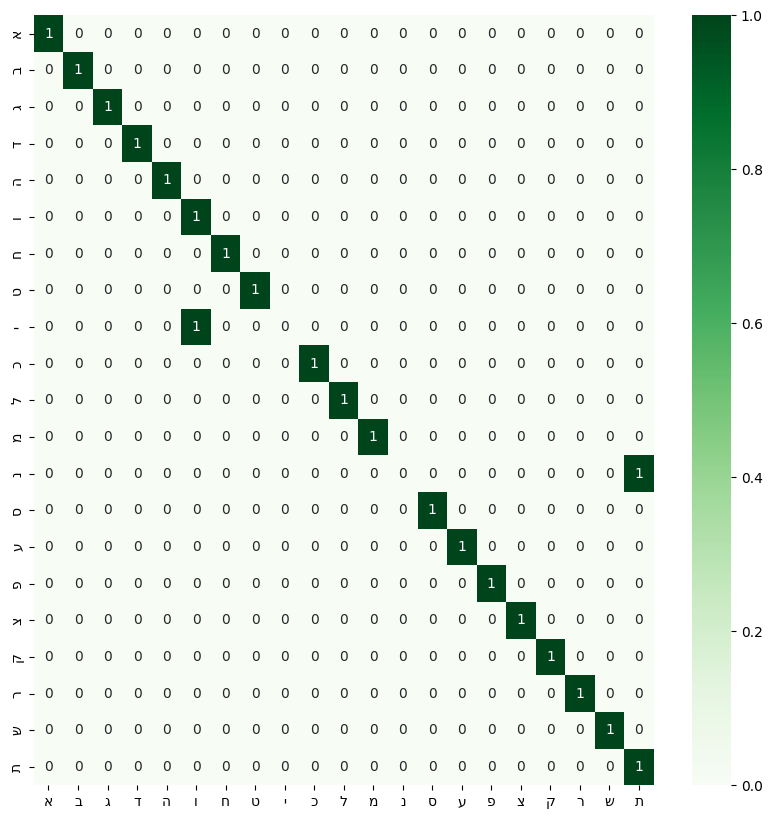

Accuracy score :  0.9047619047619048
Precision score :  0.8571428571428571
Recall score :  0.9047619047619048
F1 score :  0.8730158730158729


c:\Users\nechd\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [7]:
# load the trained model
# model.load_state_dict(torch.load('Isl_model.pt'))

# load the best model on the big images
model.load_state_dict(torch.load('ISL_big_images_best.pt'))
model = model.to(device)

# test the model and create a confusion matrix
testActual,testPred = testmodel(test_loader,model=model)
confussion_matrix(confusion_matrix(testActual,testPred))

# calc and print scores
ac=accuracy_score(testActual, testPred)
pre=precision_score(testActual, testPred, average='weighted')
rec=recall_score(testActual, testPred, average='weighted')
f1=f1_score(testActual, testPred, average='weighted')
print('Accuracy score : ', ac)
print('Precision score : ', pre)
print('Recall score : ', rec)
print('F1 score : ', f1)



repeat with the cropped data set

In [8]:
# train_df = loadDataGetDF("file_name") # folder of cropped images
# train_df, valid_df = train_test_split(train_df, train_size=0.8, random_state=0)
# test_df, valid_df = train_test_split(valid_df, train_size=0.5, random_state=0)

# print("train size: ", len(train_df))
# print("val size: ", len(valid_df))
# print("test size: ", len(test_df))

# load only test data
test_df = loadtestdata("C:/Users/nechd/Desktop/sign/yehudit_images_cropped")
print("test size: ", len(test_df))

test size:  21


In [9]:
# train_dataset = ISLAlphabet(df=train_df, transform=train_transforms)
# valid_dataset = ISLAlphabet(df=valid_df, transform=test_transforms)
test_dataset = ISLAlphabet(df=test_df, transform=test_transforms)

# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16)
# valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=16)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1)

In [10]:
# Load the pre-trained ResNet model
model = models.resnet50(weights= ResNet50_Weights.DEFAULT).to(device)


# change the last fc layer to be 3 fc layers
In_features = model.fc.in_features
# model.fc = nn.Linear(In_features,21)
model.fc=nn.Sequential( nn.Linear(In_features,1050),
                        nn.Linear(1050,210),
                        nn.Linear(210,21))

# model.to(device)


# Define the loss function and optimizer
# loss_fn = torch.nn.NLLLoss()
# optimizer = torch.optim.Adam(params=model.parameters(),lr=0.0001,betas=(0.9,0.999),eps=1e-08,weight_decay=0,amsgrad=False)
# criterion = nn.CrossEntropyLoss()
# model.to(device)
# criterion = criterion.to(device)

# trainModel(10, model = model, train_loader = train_loader, valid_loader = valid_loader, name="Isl_model.pt")

Test Accuracy: 95 %


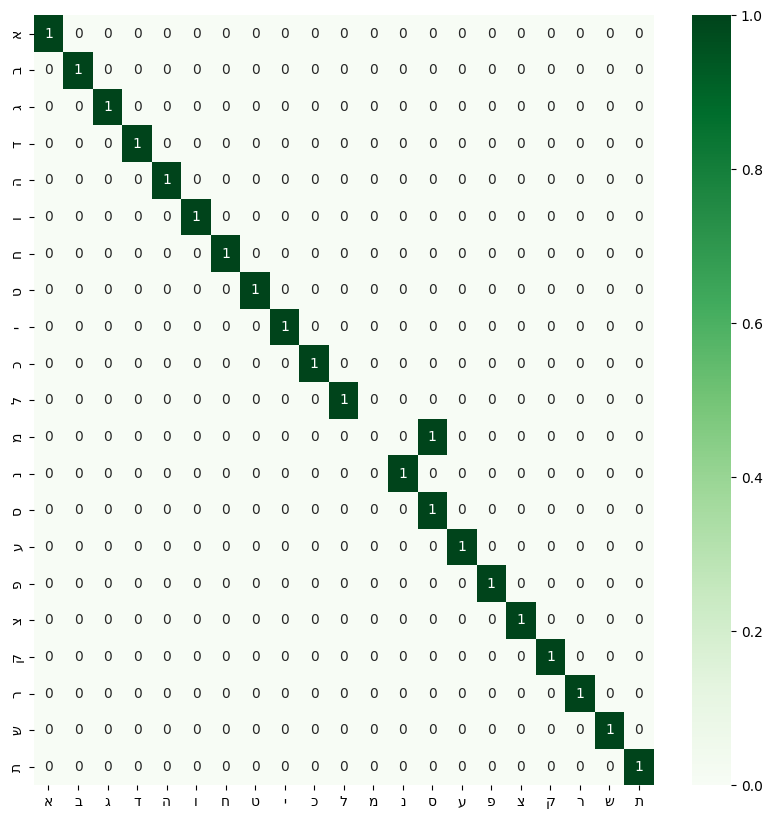

Accuracy score :  0.9523809523809523
Precision score :  0.9285714285714286
Recall score :  0.9523809523809523
F1 score :  0.9365079365079364


c:\Users\nechd\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
# model.load_state_dict(torch.load('Isl_model.pt'))
model.load_state_dict(torch.load('ISL_cropped_images_best.pt'))
model = model.to(device)

testActual,testPred = testmodel(test_loader,model=model)
confussion_matrix(confusion_matrix(testActual,testPred))

ac=accuracy_score(testActual, testPred)
pre=precision_score(testActual, testPred, average='weighted')
rec=recall_score(testActual, testPred, average='weighted')
f1=f1_score(testActual, testPred, average='weighted')
print('Accuracy score : ', ac)
print('Precision score : ', pre)
print('Recall score : ', rec)
print('F1 score : ', f1)